# Model presentation

In this brief Jupyter Notebook we will present you the model we have trained. They have been trained with two different data splits:
- one which is positional
- one which is regional.

## Some imports 


In [1]:
import os
import numpy as np
import torch
import pandas as pd
import pyranges as pr
import math 
import torch.nn as nn
from torch.amp import autocast
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM, AutoTokenizer
from tqdm import tqdm

from gnomad_db.database import gnomAD_DB


#from loss_function import CrossEntropyNucleotideLoss

from model_architecture import FineTunedSpeciesLM
from proj_loader import prepare_data_loader
import loss_mask
from loss_mask import LossMask

import sys
sys.path.append("/s/project/ml4rg_students/2025/project07/group_2/model_architecture.py")

/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialization of the model

In [2]:
# First we choose device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# We initialize the model
model = FineTunedSpeciesLM()
def count_parameters(module):
    return sum(p.numel() for p in module.parameters())

# Embeddings (frozen)
embedding_params = count_parameters(model.embeddings)

# Encoder (frozen)
encoder_params = count_parameters(model.encoder)

# Head (trainable)
head_params = count_parameters(model.head)

print(f"Embeddings parameters: {embedding_params:,}")
print(f"Encoder parameters:    {encoder_params:,}")
print(f"Head parameters:       {head_params:,}")

cuda


You are using a model of type rotarybert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Embeddings parameters: 9,833,472
Encoder parameters:    85,054,464
Head parameters:       18,436


## Dataset
Here we initialize the dataset, so that we can take out a sample to test the two models 

In [3]:
import torch
from torch.utils.data import Dataset

import pandas as pd
from gnomad_db.database import gnomAD_DB

# Load the model
model_name = "johahi/specieslm-metazoa-upstream-k6"

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)


#database_location = '/s/project/benchmark-lm/ssd-cache'
database_location = '/s/project/ml4rg_students/2025/project07/data/gnomad4_1_allele_number'
db = gnomAD_DB(database_location, gnomad_version="v4")

nuc_to_int_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
revcomp_dict = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}

def one_hot_seq(seq):
    
    seq = seq.upper()
    one_hot = np.zeros((len(seq), 4), dtype=int)
    for i, nucleotide in enumerate(seq):
        if nucleotide == 'A':
            one_hot[i, 0] = 1
        elif nucleotide == 'C':
            one_hot[i, 1] = 1
        elif nucleotide == 'G':
            one_hot[i, 2] = 1
        elif nucleotide == 'T':
            one_hot[i, 3] = 1
        else:
            raise ValueError(f"Unknown nucleotide {nucleotide} at position {i} in sequence {seq}")
    return one_hot

import polars as pl

scores_lazy = pl.scan_parquet(
    "/s/project/benchmark-lm/data/gnomad4_1_allele_number/"
)
scores_lazy



def get_af_from_interval(interval):

    df_region = db.get_info_for_interval(chrom=interval['Chromosome'].values[0].strip('chr'), 
        interval_start=interval['Start'].values[0] + 1, #IMPORTANT 1 BASED COORDINATES IN GnomAD
        interval_end=interval['End'].values[0], query="*") #END IS INCLUDED

    #only consider SNPs that Pass the gnomad filtering criteria
    df_region = df_region[df_region['filter'] == 'PASS'].copy()
    df_region['len_ref'] = df_region['ref'].apply(len)
    df_region['len_alt'] = df_region['alt'].apply(len)
    df_region = df_region[(df_region['len_ref'] == 1) & (df_region['len_alt'] == 1)].copy().reset_index(drop=True)

    if interval['Strand'].values[0] == '+':
        df_region['relative_pos'] = (df_region['pos'] - (interval['Start'].values[0] + 1)).astype(int)  # this is zero based

        df_region['ref_int'] = df_region['ref'].map(nuc_to_int_dict).astype(int)
        df_region['alt_int'] = df_region['alt'].map(nuc_to_int_dict).astype(int)

        interval_length = interval['End'].values[0] - interval['Start'].values[0]
        afs_arr = np.zeros((interval_length, 4))
        afs_arr[df_region['relative_pos'].values, df_region['alt_int'].values] = df_region['AF'].values

        one_hot_arr = one_hot_seq(interval['seq'].values[0])

        afs_arr[one_hot_arr==1] = 1 - afs_arr.sum(axis=-1)

    elif interval['Strand'].values[0] == '-':
        df_region['relative_pos'] = (interval['End'].values[0] - df_region['pos']).astype(int)

        df_region['ref_int'] = df_region['ref'].map(revcomp_dict).map(nuc_to_int_dict).astype(int)
        df_region['alt_int'] = df_region['alt'].map(revcomp_dict).map(nuc_to_int_dict).astype(int)

        interval_length = interval['End'].values[0] - interval['Start'].values[0]
        afs_arr = np.zeros((interval_length, 4))
        afs_arr[df_region['relative_pos'].values, df_region['alt_int'].values] = df_region['AF'].values

        one_hot_arr = one_hot_seq(interval['seq'].values[0])
        afs_arr[one_hot_arr==1] = 1 - afs_arr.sum(axis=-1)

    return afs_arr, df_region 

proxy_species = 'homo_sapiens'
assert proxy_species in tokenizer.get_vocab()

def kmers(seq, k=6): #for codons, k = 6
    # splits a sequence into non-overlappnig k-mers
    return [seq[i:i + k] for i in range(0, len(seq), k) if i + k <= len(seq)]

def kmers_stride1(seq, k=6):
    # splits a sequence into overlapping k-mers
    return [seq[i:i + k] for i in range(0, len(seq)-k+1)]  

def tok_func_species(seq, proxy_species):
    res = tokenizer(proxy_species + " " +  " ".join(kmers_stride1(seq)))
    return res

class GnomADIntervalSpeciesLMDataset(Dataset):
    def __init__(self, seqs_df, minimum_total_allele_number=150788):
        self.seqs_df = seqs_df
        self.minimum_total_allele_number = minimum_total_allele_number # 99% of positions in the human genome are above this. Meaning for 99% of positions we have data on minimum_total_allele_number/2 or more individuals (/2 because each human has 2 sets of chromosome from the father and mother)
    
    def __len__(self):
        return len(self.seqs_df)
    
    def __getitem__(self, idx):
        interval = self.seqs_df.iloc[idx].to_frame().T
        afs_arr, _ = get_af_from_interval(interval)
        an_df = scores_lazy.filter((pl.col("chrom") == interval['Chromosome'].values[0]) & (pl.col("pos") >= interval['Start'].values[0]+1) & (pl.col("pos") <= interval['End'].values[0])).collect().to_pandas()
        an_arr = an_df['AN'].values if interval['Strand'].values[0] == '+' else an_df['AN'].values[::-1]
        an_mask = an_arr < self.minimum_total_allele_number
        input_ids = tok_func_species(interval['seq'].values[0], proxy_species=proxy_species)['input_ids']
        
        
        return {
            'labels': torch.tensor(afs_arr.copy(), dtype=torch.float32),
            'an_arr': torch.tensor(an_arr.copy(), dtype=torch.long),
            'an_mask': torch.tensor(an_mask.copy(), dtype=torch.bool), #True if the position does not pass the quality criteria of the minimum_total_allele_number
            'input_ids': torch.tensor(input_ids, dtype=torch.long)
        }

Here we call the dataset:

In [4]:
seqs_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/data/gtf_start_extended_ints_df_2003_seq.csv')
print (seqs_df)

      Chromosome     Start       End Strand  \
0           chr1     63564     65567      +   
1           chr1    922431    924434      +   
2           chr1    923941    925944      +   
3           chr1    958693    960696      +   
4           chr1    964531    966534      +   
...          ...       ...       ...    ...   
30055      chr22  50577912  50579915      -   
30056      chr22  50582778  50584781      -   
30057      chr22  50627776  50629779      -   
30058      chr22  50627369  50629372      -   
30059      chr22  50782291  50784294      -   

                                                     seq  seq_len  
0      TATCGATGGGCACCTTCTTTTTCTTAATTGTATCATACATTTTTAT...     2003  
1      AGAAGACACAGACTTCAGGAGAGGAAGGCACAGGAACTCACTGGCA...     2003  
2      TCCCCGCCGGGCGGGCGCGCGCCAGTGGACGCGGGTGCACGACTGA...     2003  
3      TCGGGAAGAGATTTTTGCACAACTCACCAACATACGCTCCCTGCCT...     2003  
4      TCCGCAGTGGGGCTGCGGGGAGGGGGGCGCGGGTCCGCAGTGGGGC...     2003  
...                        

Now just some code for the plotting

In [5]:
import matplotlib
import matplotlib.pyplot as plt

def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(
            matplotlib.patches.Polygon(
                (np.array([1,height])[None,:]*polygon_coords
                 + np.array([left_edge,base])[None,:]),
                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.825, base+0.085*height],
        width=0.174, height=0.415*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.625, base+0.35*height],
        width=0.374, height=0.15*height,
        facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
        width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
        width=1.0, height=0.2*height, facecolor=color,
        edgecolor=color, fill=True))

    
def plot_u(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.95, height=0.8*height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.025, base+0.4*height], width=0.95, height=0.6*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.6175, height=0.52*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.19125, base+0.4*height], width=0.6175, height=0.6*height,
        facecolor='white', edgecolor='white', fill=True))
    """ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))"""
    

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}


def plot_weights_given_ax(ax, array,          
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.show()
    
    
def dna_plot_weights(array, **kwargs):
  plot_weights(array=array, plot_funcs=dna_plot_funcs, **kwargs)


def rna_plot_weights(array, **kwargs):
  plot_weights(array=array, plot_funcs=rna_plot_funcs, **kwargs)

In [6]:
#computes per position information content to scale the probabilities for better visualization

def compute_per_position_ic(ppm, 
                            background=torch.tensor([0.295, 0.205, 0.205, 0.295]), #[0.295, 0.205, 0.205, 0.295]background nucleotide frequency in Human
                            pseudocount=0):
    ppm=ppm.unsqueeze(0)
    alphabet_len = len(background)
    bg = torch.log2(background)*background
    pseudocounted_ppm = (ppm+pseudocount)/(1 + pseudocount*alphabet_len)
    ic = torch.log2(pseudocounted_ppm)*ppm - bg.unsqueeze(0)
    return torch.sum(ic,axis=2)

## A sample

This is what a sample from the dataset looks like

In [7]:
gnomad_dataset = GnomADIntervalSpeciesLMDataset(seqs_df)
sample = gnomad_dataset[0]

In [8]:
sample

{'labels': tensor([[0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]]),
 'an_arr': tensor([111140, 111084, 111534,  ...,   2554,   2634,   2644]),
 'an_mask': tensor([True, True, True,  ..., True, True, True]),
 'input_ids': tensor([   2, 4333, 1137,  ...,  854, 3404,    3])}

Here is the plot of this sample:

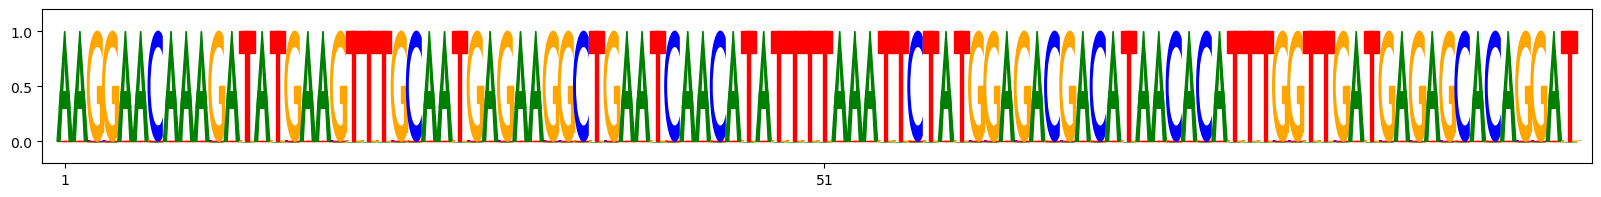

In [9]:
to_plot = sample['labels']
fraction_to_plot = to_plot[250:350,:]

plot_weights((fraction_to_plot.swapaxes(0,1)).numpy(), subticks_frequency=50)


## Fine-Tuned SpeciesLM Architecture

We start from a **RotaryBertForMaskedLM** backbone (hidden size = 768), whose embeddings and transformer encoder are _frozen_ to preserve pretrained representations. On top of the encoder’s outputs we add a **ConvTranspose1d** head that upsamples back to our original nucleotide sequence length.

1. **Input & Encoder**  
   - **Input IDs**: `[batch_size, seq_len=2003]`  
   - After word & position embeddings → shape `(B, 2003, 768)`  
   - Through 12 rotary-BERT layers (frozen) → shape `(B, 2003, 768)`

2. **Remove special tokens**  
   - RotaryBERT adds 2 special tokens at start and 1 at end → effective length 2001  
   - We strip these out:  
     ```python
     x = x[:, 2:-1, :]   # from (B, 2001, 768) to (B, 1998, 768)
     ```

3. **ConvTranspose1d head**  
   - **Permute** for convolution: `(B, 1998, 768)` → `(B, 768, 1998)`  
   - **Upsample** via `ConvTranspose1d(in_channels=768, out_channels=4, kernel_size=6)`  
     - Formula: `(L_in−1)*stride − 2*pad + kernel = (1998−1)*1 − 0 + 6 = 2003`  
     - Output shape: `(B, 4, 2003)`  
   - **Permute back** to `(B, 2003, 4)`  
     - These 4 channels represent raw logits for {A, C, G, T} at each of the 2003 positions.

4. **Post-processing**  
   - At inference time, apply  
     ```python
     probs = torch.softmax(logits, dim=-1)  # → (B, 2003, 4) probabilities
     ```  
   - Then pick the highest-probability base or compute cross-entropy loss directly on logits during training.

---

**Key points:**
- The **ConvTranspose1d** head learns how to “stretch” the 1998 encoder time-steps back to our original 2003-long sequence, without manual padding hacks.
- We maintain a **per-position** classifier over 4 classes, producing one logit vector \([l_A, l_C, l_G, l_T]\) per nucleotide.
- Freezing the backbone keeps training light: only the ~1 million weights in the transposed-conv head are updated.


## Model trained with regional splits
The model in this case was fine tuned between 10 to 20 epochs (We do not know exactly how many because we let it train overnight and then in the morning the workbench was disconnected)

In [10]:
# First we choose device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# We initialize the model
model = FineTunedSpeciesLM()

ckpt = torch.load('/s/project/ml4rg_students/2025/project07/checkpoints_regional/best_model_regional.pt', map_location=device)

# Populate your model’s parameters
model.load_state_dict(ckpt)

cuda


You are using a model of type rotarybert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
/scratch/tmp/s_aotto/ipykernel_2568180/1401608808.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pl

<All keys matched successfully>

In [11]:
input_ids       = sample['input_ids']               # shape: [2003]
attention_mask  = torch.ones_like(input_ids, dtype=torch.bool)       # shape: [2003]


input_ids       = input_ids.unsqueeze(0).to(device)        # shape: [1, 2003]
attention_mask  = attention_mask.unsqueeze(0).to(device)   # shape: [1, 2003]

# ← MAKE SURE TO PUT THE MODEL ON DEVICE
model.to(device)        


model.eval()
with torch.no_grad():
    out = model(input_ids=input_ids,
                attention_mask=attention_mask)


In [12]:
#We check the shape
print(out.shape)

#then we apply softmax on the 3rd dim
out_logits = out
#Now to be plotted we take the same as before, so from nucleotide 250 to nucleotide 350
cutted_out = out_logits[:,250:350,:]
print(cutted_out)

torch.Size([1, 2003, 4])
tensor([[[ 1.2846e+01, -3.5479e+00, -3.2299e+00, -6.2504e+00],
         [ 1.4143e+01, -7.0851e+00, -3.6194e+00, -1.4759e+00],
         [-1.2334e+01, -1.0903e+01,  1.0008e+01, -6.5763e+00],
         [-2.1420e+00, -4.0441e+00,  1.0288e+01, -8.2750e+00],
         [ 8.6531e+00,  8.6111e-01, -1.5326e+00, -1.9956e+00],
         [ 1.1171e+01, -9.6821e+00, -2.2386e+00, -2.3698e+00],
         [ 2.0328e+00,  1.8791e+01,  5.9963e-01, -5.6272e-01],
         [ 1.2646e+01, -1.2496e+00, -8.0749e-01, -4.2271e+00],
         [ 1.1484e+01, -4.7510e+00,  9.5263e-01, -2.7923e-01],
         [ 1.5642e+01, -7.6566e-01,  2.4658e+00, -3.3202e+00],
         [-4.0174e+00, -4.5593e+00,  1.1547e+01, -7.3383e+00],
         [ 1.4044e+01, -5.2434e+00,  1.8910e+00, -2.5025e+00],
         [ 4.2208e-01,  3.6172e+00, -3.7522e-01,  1.3245e+01],
         [ 9.0095e+00, -1.6599e+00, -3.6530e+00, -1.0665e+00],
         [-2.7292e-01, -3.6633e+00, -1.2190e+00,  1.4515e+01],
         [-4.9539e+00, -1.2112

In [13]:
out

tensor([[[-2.2895, -1.9521, -0.6879,  3.6702],
         [ 8.9295, -2.3852,  1.9681, -3.3943],
         [-4.4396, -8.2187,  0.0682,  8.1640],
         ...,
         [ 9.3964,  0.0332,  3.6641, -3.9026],
         [ 2.3338,  3.3862,  0.9507,  7.1209],
         [ 2.1465, -2.1181,  3.0903,  2.2717]]])

Now we plot a part of the output:

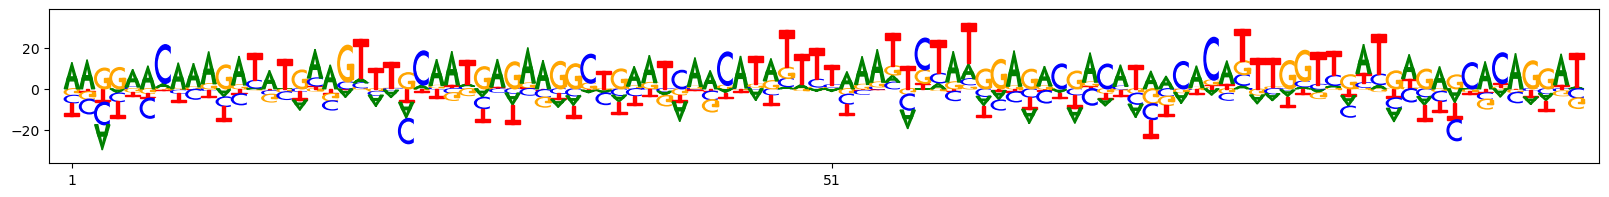

In [13]:
plot_weights(((cutted_out.cpu()).swapaxes(0,1)).numpy(), subticks_frequency=50)

## Model trained with positional splits
Also in this case we are not sure exactly how many epoch did it train, but we assume it was from 15 to 20. 

cpu


You are using a model of type rotarybert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
/scratch/tmp/s_gjamn/ipykernel_42589/4161806327.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Plea

 INPUT SIZE: torch.Size([1, 2001])
 AFTER EMBEDDINGS:  torch.Size([1, 2001, 768])
 AFTER ENCODER:  torch.Size([1, 2001, 768])
 AFTER REMOVING SPECIAL TOKENS:  torch.Size([1, 1998, 768])
 AFTER PERMUTATION:  torch.Size([1, 768, 1998])
 AFTER TRANSPOSE CONV HEAD:  torch.Size([1, 4, 2003])
 AFTER PERMUTATION:  torch.Size([1, 2003, 4])
torch.Size([1, 2003, 4])
tensor([[[9.9833e-01, 4.1769e-04, 1.1410e-04, 1.1415e-03],
         [3.1196e-05, 1.7715e-05, 1.4615e-05, 9.9994e-01],
         [1.3608e-06, 9.9992e-01, 7.3762e-05, 8.6547e-07],
         [3.5278e-04, 1.3287e-09, 9.9965e-01, 1.7993e-07],
         [9.9743e-01, 2.8092e-04, 2.9731e-04, 1.9889e-03],
         [3.7605e-10, 5.6180e-07, 5.4795e-08, 1.0000e+00],
         [2.4702e-06, 5.5672e-08, 1.0000e+00, 3.3281e-10],
         [6.7982e-07, 5.0015e-10, 1.0000e+00, 3.6119e-10],
         [6.1204e-08, 8.4717e-12, 1.0000e+00, 3.4298e-10],
         [1.3832e-06, 1.0000e+00, 1.6411e-06, 2.6779e-08],
         [1.0000e+00, 7.1509e-09, 1.0653e-07, 4.850

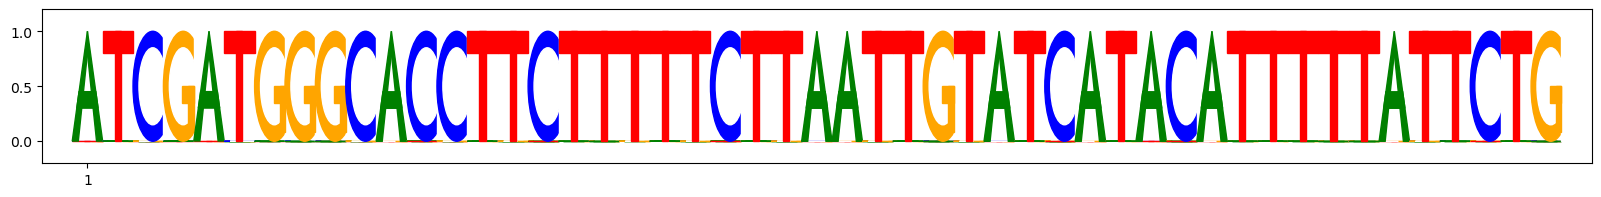

Parametri totali: 94906372
Parametri allenabili: 18436


In [15]:
# First we choose device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# We initialize the model
model = FineTunedSpeciesLM()

ckpt = torch.load('/s/project/ml4rg_students/2025/project07/checkpoints/best_model.pt', map_location=device)

# Populate your model’s parameters
model.load_state_dict(ckpt)

input_ids       = sample['input_ids']               # shape: [2003]
attention_mask  = torch.ones_like(input_ids, dtype=torch.bool)       # shape: [2003]


input_ids       = input_ids.unsqueeze(0).to(device)        # shape: [1, 2003]
attention_mask  = attention_mask.unsqueeze(0).to(device)   # shape: [1, 2003]

# ← MAKE SURE TO PUT THE MODEL ON DEVICE
model.to(device)        


model.eval()
with torch.no_grad():
    out = model(input_ids=input_ids,
                attention_mask=attention_mask)

#We check the shape
print(out.shape)

#then we apply softmax on the 3rd dim
Softmax = nn.Softmax(dim=-1)
out_probs = Softmax(out)

#Now to be plotted we take the same as before, so from nucleotide 250 to nucleotide 350
cutted_out = out_probs[:,1:50,:]
print(cutted_out)

plot_weights(((cutted_out.cpu()).swapaxes(0,1)).numpy(), subticks_frequency=50)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parametri totali: {total_params}")
print(f"Parametri allenabili: {trainable_params}")


In [16]:

import torch
from torch.utils.data import DataLoader

# Prepare the dataset and dataloader
gnomad_dataset = GnomADIntervalSpeciesLMDataset(seqs_df)
data_loader = DataLoader(gnomad_dataset, batch_size=256, shuffle=False)

# Load the model and set to eval
model = FineTunedSpeciesLM()
model.eval()

# Get one batch
#batch = next(iter(data_loader))
data_iter = iter(data_loader)  # only do this once
batch = next(data_iter)  # first batch
input_ids = batch["input_ids"]  # shape: [256, 2001]

# Forward pass
with torch.no_grad():
    logits = model(input_ids)  # shape: [256, 2003, 4]
    probs = torch.softmax(logits, dim=-1)  # shape: [256, 2003, 4]

# Search for a sample with variation between 0.2 and 0.6
min_prob, max_prob = 0.2, 0.6
found = []

for sample_idx in range(probs.shape[0]):             # loop over 256 samples
    for pos in range(probs.shape[1]):                # loop over 2003 positions
        p = probs[sample_idx, pos]                   # shape: [4]
        for i, val in enumerate(p):
            if min_prob <= val.item() <= max_prob:
                found.append({
                    "sample": sample_idx,
                    "position": pos,
                    "probs": [round(v.item(), 3) for v in p]
                })
                break
        if len(found) >= 10:
            break
    if len(found) >= 10:
        break

# Print some results
for entry in found:
    s = entry["sample"]
    pos = entry["position"]
    p = entry["probs"]
    print(f"Sample {s}, Position {pos}: {p}")



You are using a model of type rotarybert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


 INPUT SIZE: torch.Size([256, 2001])
 AFTER EMBEDDINGS:  torch.Size([256, 2001, 768])
 AFTER ENCODER:  torch.Size([256, 2001, 768])
 AFTER REMOVING SPECIAL TOKENS:  torch.Size([256, 1998, 768])
 AFTER PERMUTATION:  torch.Size([256, 768, 1998])
 AFTER TRANSPOSE CONV HEAD:  torch.Size([256, 4, 2003])
 AFTER PERMUTATION:  torch.Size([256, 2003, 4])
Sample 0, Position 2: [0.0, 0.667, 0.329, 0.004]
Sample 0, Position 12: [0.268, 0.591, 0.134, 0.007]
Sample 0, Position 20: [0.0, 0.304, 0.696, 0.0]
Sample 0, Position 29: [0.743, 0.002, 0.253, 0.002]
Sample 0, Position 35: [0.001, 0.543, 0.001, 0.455]
Sample 0, Position 39: [0.0, 0.42, 0.58, 0.0]
Sample 0, Position 44: [0.001, 0.246, 0.753, 0.0]
Sample 0, Position 51: [0.0, 0.235, 0.765, 0.0]
Sample 0, Position 55: [0.0, 0.096, 0.369, 0.535]
Sample 0, Position 57: [0.0, 0.0, 0.638, 0.362]


Dodala nekaj kode (gaja) ------------------------------------------------------------------

In [21]:
probs.shape

torch.Size([256, 2003, 4])

In [22]:
seqs09_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/group_2/data/seqs_2009.csv')

In [25]:
batch1_df = seqs09_df.iloc[:256]
batch1_df['nuc_probs'] = [probs[i] for i in range(probs.size(0))]
batch1_df

/scratch/tmp/s_gjamn/ipykernel_42589/2877551258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch1_df['nuc_probs'] = [probs[i] for i in range(probs.size(0))]


,Chromosome,Start,End,seq,seq_len,nuc_probs
0,chr1,63561,65570,TCATATCGATGGGCACCTTCTTTTTCTTAATTGTATCATACATTTT...,2009,"[[tensor(0.0007), tensor(0.8263), tensor(0.163..."
1,chr1,922428,924437,GGGAGAAGACACAGACTTCAGGAGAGGAAGGCACAGGAACTCACTG...,2009,"[[tensor(1.4378e-05), tensor(0.9922), tensor(0..."
2,chr1,923938,925947,AAGTCCCCGCCGGGCGGGCGCGCGCCAGTGGACGCGGGTGCACGAC...,2009,"[[tensor(5.9918e-06), tensor(0.5547), tensor(0..."
3,chr1,958690,960699,AGATCGGGAAGAGATTTTTGCACAACTCACCAACATACGCTCCCTG...,2009,"[[tensor(7.9241e-06), tensor(0.9904), tensor(0..."
4,chr1,964528,966537,AGGTCCGCAGTGGGGCTGCGGGGAGGGGGGCGCGGGTCCGCAGTGG...,2009,"[[tensor(4.3525e-05), tensor(0.3728), tensor(0..."
...,...,...,...,...,...,...
251,chr1,25744714,25746723,AATTTCAGAAGGATTCTCTGCCTTCAGTCAACACAAGTGAGCAGTT...,2009,"[[tensor(1.8589e-05), tensor(0.9570), tensor(0..."
252,chr1,25798227,25800236,GACACCTCCCAGAGCTGACATCTCCCAGAGCTGGGCCCAAGATTGA...,2009,"[[tensor(2.0285e-06), tensor(0.8755), tensor(0..."
253,chr1,25821101,25823110,AATGTGGTCTAGAGACGGCAGAGAAAGATGGGTTTGGGACTGATTG...,2009,"[[tensor(0.0005), tensor(0.9952), tensor(0.003..."
254,chr1,25824663,25826672,CGCAGGGGTAGGGGGCAGGAAAAGCTGTCCCAGTATTCAGATTGCC...,2009,"[[tensor(8.4415e-07), tensor(0.9999), tensor(7..."


In [26]:
batch1_df['nuc_probs'][0].shape

torch.Size([2003, 4])

In [27]:
neutral_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/group_2/data/merged.csv')
neutral_df

,Unnamed: 0.1,Unnamed: 0,sequence_context,total_count,var_count,var_freq,ref,alt,estimated_p_mutated
0,0,0,TATCGAT,354,30,0.084746,C,A,0.006495
1,1,1,TATCGAT,354,169,0.477401,C,T,0.085112
2,2,2,TATCGAT,354,41,0.115819,C,G,0.004966
3,3,3,CGATGGG,1225,237,0.193469,T,C,0.013260
4,4,4,CGATGGG,1225,62,0.050612,T,A,0.002437
...,...,...,...,...,...,...,...,...,...
49145,49145,49147,ACGAACG,294,16,0.054422,A,G,0.003210
49146,49146,49148,ACGAACG,294,6,0.020408,A,T,0.000977
49147,49147,49149,TCGAACG,238,4,0.016807,A,G,0.003399
49148,49148,49150,TCGAACG,238,2,0.008403,A,C,0.000944


In [ ]:
# Iterate over regions
for _, row in batch1_df.iterrows():
        sequence = row['seq']
        probs = row['nuc_probs'] 

        print(sequence)

        # Iterate nucleotides in sequence
        for i in range(3, len(sequence) - 3):
                
                nuc_number = i-3 #nucelotide location in the original sequence
                nucleotide = sequence
                context_7mer = sequence[i-3:i+4]
                print(context_7mer)
                break

                # Locate the row(s) where seq_context matches the target in neutral model
                matched_row = neutral_df[neutral_df['seq_context'] == target_seq]

                # Extract the data
                if not matched_row.empty:
                        ref = matched_row['ref'].values[0]
                        alt = matched_row['alt'].values[0]
                        prob = matched_row['prob'].values[0]
                        print(f"ref: {ref}, alt: {alt}, prob: {prob}")
                else:
                        print(f"No match found for {target_seq}")

                


                break

        break

TCATATCGATGGGCACCTTCTTTTTCTTAATTGTATCATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGATTTATCCAAAGCATTCTTCACTTCGTCGGCTCACATCACCGTAGTGGTTTTGTTTTTTGCTCCATGCATGTTTCTCTACGTGTGGCCTTTCCCTACTAAGTCATTGGATAAATTTTTTGCCATCATGAACTTTGTTGTCACCCCTGTCGTAAATCCTGCCATCTATACTTTAAGGAACAAAGATATGAAGTTTGCAATGAGAAGGCTGAATCAACATATTTTAAATTCTATGGAGACGACATAACACATTTGGTTGATGAGAGCACAGGATAAATGCCATGGACCATCAAGACTCCTGTGATCACCATGATCACTATGGAACGCGCACATTTTTAGTATTGCCTGAAAAAACTGAAAAATCTGCAAAAAGGATGCATTAAATCTAAGAATTGTATTTCAGATAAAGTTGCAACATTTTTTGTTAATCATAAAAAGTATATATTTCTATCTAATGTGTGTATCTAATTAACAGCAATGACTACCTTTAATTTTGATGTAGTTATTTTATATCTGTATATAAGCACATACACATATATATGACCTAGGTTTATTTATCAGTATTTTTATGCTGATAATAAGCATCACTGGAAATTAATTTTCTTATGGAAATTATGTGGATCCAATGGATAAAATATGAGTTTATATAAATTAGTAAATGCCAAAATCAAGGAAGAAACAATTTTTATTTTAATTGTACTTTAAGTTAGATAAATGGTAAGGTCAACAGCTTGTTACAACCCTTAAGTATTATTTTCAGGCTGATTGTCAATATGTTTTGTACAATGTTCTCACTTATAGGTGGGAATTGAACAATGAGAACACATGGACACAGGAAGGGGAACATCACACACCGGGGCCTGTTGTGGGGTGGGGGGAAGGGGGAGGGATAGCATTAGGAGATATAACTAGTGTTAAATG

konec dodatka ------------------------------------------------------------

In [19]:
probs.shape

torch.Size([256, 2003, 4])

In [21]:
first_sample = probs[0]  # shape: torch.Size([2003, 4])
first_sample

tensor([[6.1905e-02, 5.4928e-03, 4.0980e-03, 9.2850e-01],
        [3.5870e-03, 9.5289e-06, 5.2421e-04, 9.9588e-01],
        [9.6399e-01, 1.3674e-08, 4.4658e-08, 3.6009e-02],
        ...,
        [3.8785e-03, 7.4827e-02, 8.8343e-01, 3.7864e-02],
        [8.3789e-05, 2.6012e-02, 8.3425e-01, 1.3966e-01],
        [2.8672e-04, 3.7479e-04, 9.9452e-01, 4.8135e-03]])

In [17]:
# Estrai sample 0 come mini-batch
sample_0 = {
    "input_ids": batch["input_ids"][0].unsqueeze(0)
}
if "attention_mask" in batch:
    sample_0["attention_mask"] = batch["attention_mask"][0].unsqueeze(0)
if "token_type_ids" in batch:
    sample_0["token_type_ids"] = batch["token_type_ids"][0].unsqueeze(0)

# Inference
with torch.no_grad():
    logits = model(**sample_0)
    out_probs = torch.softmax(logits, dim=-1)

# Ora puoi passare out_probs al tuo codice di analisi


 INPUT SIZE: torch.Size([1, 2001])
 AFTER EMBEDDINGS:  torch.Size([1, 2001, 768])
 AFTER ENCODER:  torch.Size([1, 2001, 768])
 AFTER REMOVING SPECIAL TOKENS:  torch.Size([1, 1998, 768])
 AFTER PERMUTATION:  torch.Size([1, 768, 1998])
 AFTER TRANSPOSE CONV HEAD:  torch.Size([1, 4, 2003])
 AFTER PERMUTATION:  torch.Size([1, 2003, 4])


tensor([[[4.2636e-01, 1.7270e-04, 5.0166e-01, 7.1803e-02],
         [2.8316e-02, 1.3687e-03, 2.7892e-03, 9.6753e-01],
         [9.5412e-01, 1.0773e-07, 4.4419e-03, 4.1441e-02],
         [9.9992e-01, 1.8898e-10, 4.2456e-05, 3.4508e-05],
         [9.9998e-01, 9.4250e-15, 7.0576e-08, 2.1023e-05],
         [2.9229e-02, 2.8969e-07, 9.0316e-01, 6.7611e-02],
         [9.9948e-01, 6.8679e-09, 5.2228e-04, 1.7727e-06],
         [9.9876e-01, 9.7704e-17, 1.2383e-03, 3.2707e-07],
         [2.8549e-01, 1.6734e-07, 6.7460e-01, 3.9902e-02],
         [8.4539e-01, 1.2882e-13, 1.5375e-01, 8.6062e-04],
         [3.2485e-02, 2.6530e-11, 9.6206e-01, 5.4569e-03],
         [2.2254e-01, 1.0102e-08, 3.1217e-01, 4.6528e-01],
         [7.8235e-09, 1.4922e-11, 1.0000e+00, 1.8232e-13],
         [1.8342e-02, 1.6842e-10, 9.7253e-01, 9.1320e-03],
         [1.3806e-02, 1.5596e-07, 9.8619e-01, 3.0983e-07],
         [1.3203e-01, 6.5538e-09, 6.7349e-01, 1.9449e-01],
         [1.1394e-02, 5.8689e-14, 2.9581e-05, 9.8858e-01

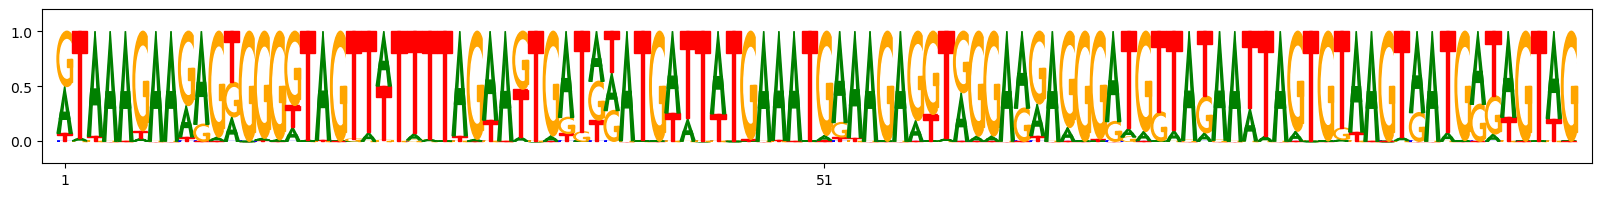

In [ ]:
cutted_out = out_probs[:,0:100,:]
print(cutted_out)

plot_weights(((cutted_out.cpu()).swapaxes(0,1)).numpy(), subticks_frequency=50)